# Simulating Onset Age Distribution of anti-GABABR Autoimmune Encephalitis from Published Summary Statistics

This Python notebook demonstrates the robustness of a statistical workflow for reconstructing age-at-onset distributions using real-world evidence from autoimmune encephalitis (AIE).


## Workflow Overview

1. Define rationale: justify selection of plausible distributions based on clinical understanding of disease onset

2. Fit candidate distributions:
   - Fit the following four distributions: log-normal, weibull, generalized gamma, and metalog
3. Estimate parameters:
   - Use quantile matching based on known median, q1, and q3 (simplified input scenario)
4. Evaluate goodness-of-fit:
   - Calculate the sum of squared differences between modelled and observed quantiles
   - Identify the best-fitting distribution
5. Visual assessment:
   - Plot modelled vs. empirical cdfs for the selected distribution
6. Sensitivity analysis:
   - Vary key parameters (e.g., sd within confidence intervals)
   - Compare age-band proportions across simulation scenarios
7. Robustness check:
   - Assess model performance at lower age tails (e.g., <12 years)
   - Fine-tune the model as needed for better fit
8. Estimate uncertainty:
   - Generate 95% confidence intervals for age-band proportions using bootstrap resampling


## Import required library


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma, genextreme # Importing necessary libraries for statistical distributions 
from scipy.optimize import minimize # Optimization for parameter fitting
from scipy.stats import probplot # Probability plot for visual assessment
from sklearn.metrics import mean_squared_error # Mean Squared Error for goodness-of-fit
from scipy.stats import gaussian_kde # Kernel Density Estimation for smooth CDF

## Input Data: Published summary statistics for autoimmune encephalitis


Example input data is derived from a published observational study by Lamblin et al. (2024), which investigated autoimmune encephalitis patients in France and the Netherlands. The input includes the median, 25th and 75th percentiles (Q1 and Q3), minimum and maximum values, mean, and reported sample size.

The DOI of the publication: 10.1212/NXI.0000000000200229

The detailed values are as follows:


In [3]:
median = 66
q1 = 61 
q3 = 72
min = 19
max = 88
mean = 67
size = 111

In the following distribution simulation, I will use median, q1 and q3 to fit multiple candidate distributions, using quantile matching method to optimize parameters.

## Fit candidate distributions


According to the literature on autoimmune encephalitis (AIE) onset age, the distribution is often significantly right-skewed, with a higher concentration of adult patients and fewer pediatric cases. In certain subtypes, the distribution also exhibits substantial kurtosis, deviating markedly from a normal distribution. These clinical patterns suggest that parametric distributions capable of accommodating both skewness and heavy tails are suitable candidates for simulating age distributions in real-world populations.

Including both classic distributions such as log-normal and Weibull, and more flexible ones like generalized gamma (and metalog), helps capture a wide range of distribution shapes, accounting for variations in skewness and kurtosis—that is, the asymmetry and tail heaviness of the distribution.

### Log-normal

Fit two parameters in log-normal distribution:
- mu: log-scale mean
- sigma: log-scale SD

#### Quantile matching with optimization

In [4]:
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import minimize

In [5]:
# Empirical quantiles
empirical_q = [q1, median, q3]

In [6]:
# Objective function: Minimize squared differences between model and empirical quantiles
def objective(params):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    dist = lognorm(s=sigma, scale=np.exp(mu))
    theo_q = dist.ppf([0.25, 0.5, 0.75])
    return np.sum((np.array(theo_q) - empirical_q)**2)

This defines the objective function for optimization:

- Takes parameters mu and sigma as input
- Returns infinity if sigma is non-positive (constraint)
- Calculates theoretical quantiles using the log-normal distribution with given parameters
- Returns the sum of squared differences between theoretical and empirical quantiles (this is what we want to minimize)

In [7]:
# Initial guess for mu and sigma
initial_guess = [np.log(median), 0.5]
bounds = [(0, None), (0.01, 5)]

This sets up the optimization:

- `initial_guess`: Starting values for mu (log of median) and sigma (0.5)
- `bounds`: Constraints for the parameters - mu ≥ 0, sigma between 0.01 and 5

In [8]:
# Optimize
result = minimize(objective, x0=initial_guess, bounds=bounds)
mu_fit, sigma_fit = result.x

print(f'Fitted parameters:\n mu = {mu_fit:.3f}, sigma = {sigma_fit:.3f}')

Fitted parameters:
 mu = 4.192, sigma = 0.123


This performs the actual optimization:

- Uses scipy's `minimize` function to find the best-fitting parameters
- Extracts the fitted parameters from the result
- Prints the optimized mu and sigma values

The overall process implements **quantile matching** - a method where distribution parameters are estimated by minimizing the difference between theoretical quantiles (from the assumed distribution) and empirical quantiles (from the observed data). This is particularly useful when you only have summary statistics rather than the full dataset.

#### Simulate and visualize fitted distribution

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Generate simulated onset ages
sim_ages = lognorm(s=sigma_fit, scale=np.exp(mu_fit)).rvs(10000)

The function `.rvs(10000)` generates 10,000 random variates (samples) from this fitted distribution. The result is stored in `sim_ages`, which contains 10,000 simulated onset ages

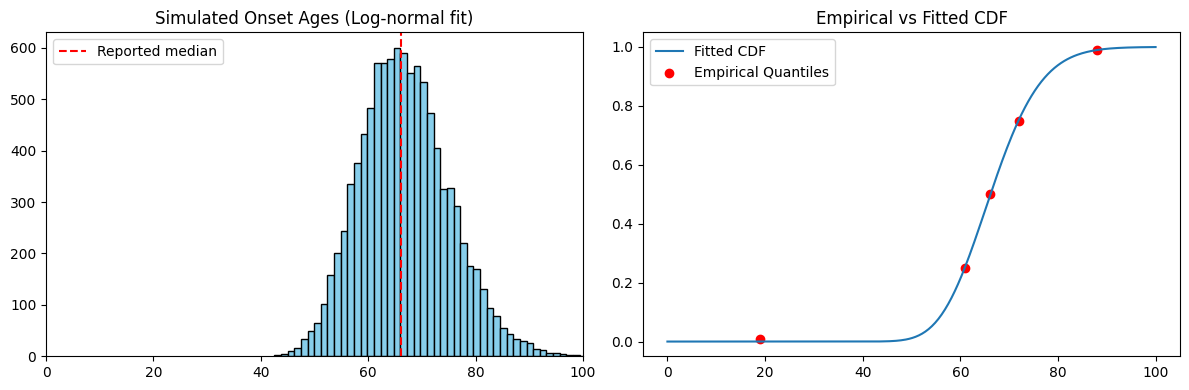

In [11]:
# Plot histogram + CDF overlay
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Histogram
ax[0].hist(sim_ages, bins=50, color='skyblue', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_xlim(0, 100)  # Set x-axis range from 0 to 100
ax[0].set_title('Simulated Onset Ages (Log-normal fit)')
ax[0].legend()

# CDF comparison
x = np.linspace(0, 100, 300) # Age range for CDF from 0 to 100
model_cdf = lognorm(s=sigma_fit, scale=np.exp(mu_fit)).cdf(x) # Call cumulative distribution function on the distribution object
ax[1].plot(x, model_cdf, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical Quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()

## Fit Weibull distribution

Fit 2-parameter Weibull distribution:
- c: Shape parameter 
- λ: Scale parameter

In [12]:
import numpy as np
from scipy.stats import weibull_min
from scipy.optimize import minimize

In [13]:
# Define quantile matching objective for Weibull
def weibull_objective(params):
    shape, scale = params
    if shape <= 0 or scale <= 0:
        return np.inf
    dist = weibull_min(c=shape, scale=scale)
    theo_q = dist.ppf([0.25, 0.5, 0.75])
    return np.sum((np.array(theo_q) - empirical_q) **2)

In [14]:
# Initial guess for shape and scale
initial_guess_weibull = [2, 10]
bounds_weibull = [(0.01, None), (0.01, None)]

result_weibull = minimize(weibull_objective, x0=initial_guess_weibull, bounds=bounds_weibull)
shape_fit_weibull, scale_fit_weibull = result_weibull.x

print(f"Fitted Weibull parameters:\n shape = {shape_fit_weibull:.3f}, scale = {scale_fit_weibull:.3f}")

Fitted Weibull parameters:
 shape = 9.460, scale = 69.247


**Setup and Optimization:**

- `initial_guess_weibull = [2, 10]`: Starting values for the optimization
  - Shape parameter (c) = 2
  - Scale parameter (λ) = 10
- `bounds_weibull = [(0.01, None), (0.01, None)]`: Parameter constraints
  - Both shape and scale must be ≥ 0.01 (positive values)
  - No upper bounds (None)

**Optimization Process:**

- `minimize(weibull_objective, x0=initial_guess_weibull, bounds=bounds_weibull)`: Uses scipy's minimize function to find the best-fitting Weibull parameters
- `weibull_objective`: The objective function defined in the previous cell that minimizes squared differences between theoretical and empirical quantiles
- `result_weibull.x`: Extracts the optimized parameters from the result

**Output:**

- `shape_fit_weibull`, `scale_fit_weibull`: The fitted shape and scale parameters

### Simulate and visualize fitted distribution

In [15]:
import matplotlib.pyplot as plt

In [16]:
# Simulate from fitted Weibull
sim_ages_weibull = weibull_min(c=shape_fit_weibull, scale=scale_fit_weibull).rvs(10000)

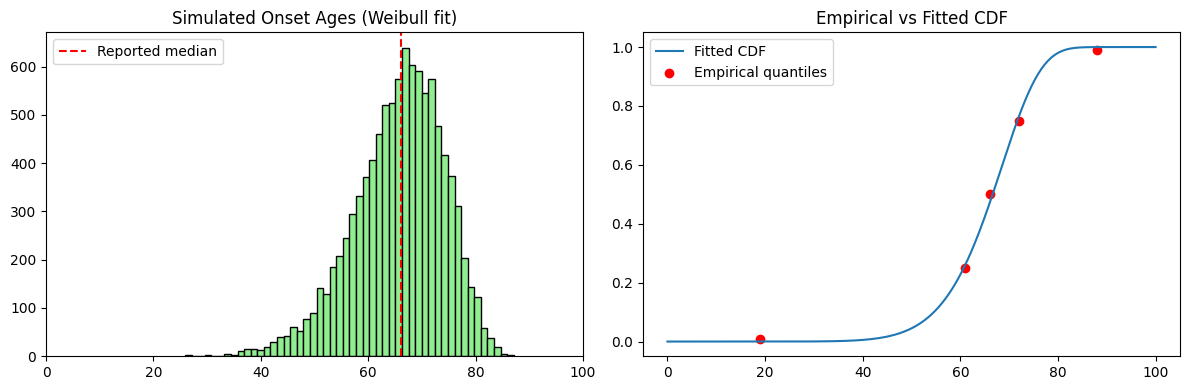

In [17]:
# Plot histogram
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(sim_ages_weibull, bins=50, color='lightgreen', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_xlim(0, 100)
ax[0].set_title('Simulated Onset Ages (Weibull fit)')
ax[0].legend()

# Plot empirical vs fitted CDF
x_weibull = np.linspace(0, 100, 300)
model_cdf_weibull = weibull_min(c=shape_fit_weibull, scale=scale_fit_weibull).cdf(x_weibull)
ax[1].plot(x_weibull, model_cdf_weibull, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()

## Generalized Gamma

The generalized Gamma distribution has three parameters to fit:
- a: shape parameter
- c: power parameter
- scale: scale parameter

In [18]:
import numpy as np
from scipy.stats import gengamma
from scipy.optimize import minimize

In [19]:
# Define the quantile-matching objective function
def gengamma_objective(params):
    a, c, scale = params
    if a <= 0 or scale <= 0:
        return np.inf
    try:
        dist = gengamma(a=a, c=c, scale=scale)
        theo_q = dist.ppf([0.25, 0.5, 0.75])
        return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
    except:
        return np.inf

In [20]:
# Run the optimization
initial_guess_gengamma = [2.0, 1.0, 10.0]
bounds_gengamma = [(0.01, None), (0.01, None), (0.01, None)]

result_gengamma = minimize(gengamma_objective, x0=initial_guess_gengamma, bounds=bounds_gengamma)
a_fit_gengamma, c_fit_gengamma, scale_fit_gengamma = result_gengamma.x

print(f"Fitted Generalized Gamma parameters:\n a = {a_fit_gengamma:.3f}, c = {c_fit_gengamma:.3f}, scale_fit_gengamma = {scale_fit_gengamma:.3f}")

Fitted Generalized Gamma parameters:
 a = 26.611, c = 1.583, scale_fit_gengamma = 8.409


/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_51726/1451994867.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [21]:
# Simulate and visualize
import matplotlib.pyplot as plt

In [22]:
# Simulate onset ages 
sim_ages_gengamma = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(10000)

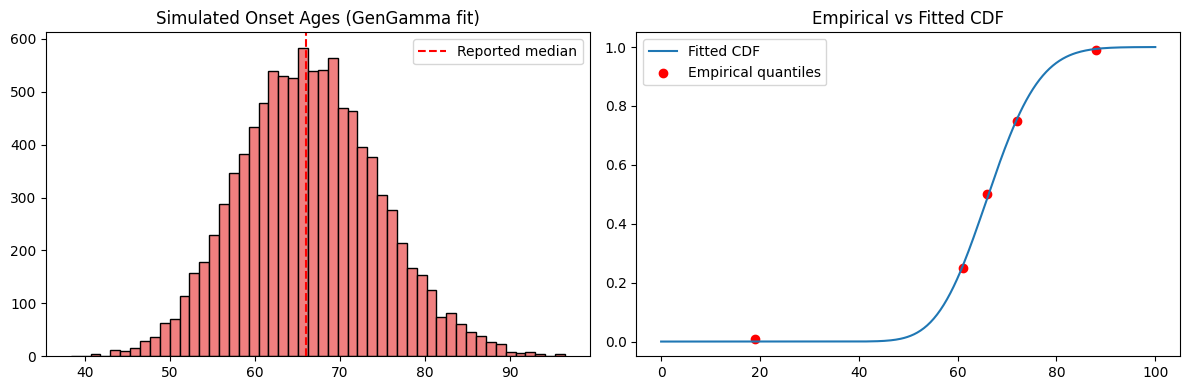

In [23]:
# Plot histogram and CDF
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Histogram
ax[0].hist(sim_ages_gengamma, bins=50, color='lightcoral', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_title('Simulated Onset Ages (GenGamma fit)')
ax[0].legend()

# CDF
x_gengamma = np.linspace(0, 100, 300)
model_cdf_gengamma = gengamma(a=a_fit_gengamma, c=c_fit_gengamma, scale=scale_fit_gengamma).cdf(x_gengamma)
ax[1].plot(x_gengamma, model_cdf_gengamma, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()


## Evaluate goodness-of-fit

Calculate the sum of squared differences between modelled and observed quantiles. Identify the best-fitting distribution.

In [24]:
# Estimate quantiles from simulated age distributions
q25, q50, q75 = np.percentile(sim_ages, [25, 50, 75])

model_quantiles = np.array([q25, q50, q75])

# Calculate squared difference between modeled- and empirical quantiles
squared_diff = (model_quantiles - empirical_q) ** 2
sum_squared_diff = np.sum(squared_diff)
print(f"Sum of squared differences: {sum_squared_diff:.4f}")


Sum of squared differences: 0.1287


In [25]:
# Initialize dictionary for simulated age distributions
simulated_ages = {
    'lognormal': sim_ages,
    'weibull': sim_ages_weibull,
    'gengamma': sim_ages_gengamma
}

# Estimate quantiles for each distribution
quantiles = {}
for dist_name, ages in simulated_ages.items():
    q25, q50, q75 = np.percentile(ages, [25, 50, 75])
    quantiles[dist_name] = np.array([q25, q50, q75])
# Calculate squared differences between modelled and empirical quantiles
squared_diffs = {}
for dist_name, model_q in quantiles.items():
    squared_diff = (model_q - empirical_q) ** 2
    sum_squared_diff = np.sum(squared_diff)
    squared_diffs[dist_name] = sum_squared_diff
# Print the sum of squared differences for each distribution
for dist_name, sum_diff in squared_diffs.items():
    print(f"Sum of squared differences for {dist_name}: {sum_diff:.4f}")

Sum of squared differences for lognormal: 0.1287
Sum of squared differences for weibull: 0.5581
Sum of squared differences for gengamma: 0.1044


In this case, the Generalized Gamma distribution shows the smallest squared difference, indicating the best fit among the three candidate distributions.

## Estimate uncertainty

In this fictional example, the goal is to estimate the proportions of cases in three age subgroups: <12 years, 12–17 years, and ≥18 years. Using the bootstrap technique, we calculate the average proportion for each subgroup along with corresponding 95% confidence intervals.

In [26]:
# Define age bands
age_bands = [(0,12), (12, 18), (18, 100)]

# Bootstrap settings
n_iterations = 1000
n_samples = 10000 # per bootstrap iteration

In [27]:
# Bootstrap simulation
bootstrap_results_gengamma = []

for _ in range(n_iterations):
    sim_ages_gengamma2 = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(n_samples)
    proportions = [np.mean((sim_ages_gengamma2 >= low) & (sim_ages_gengamma2 <= high)) for (low, high) in age_bands]
    bootstrap_results_gengamma.append(proportions)

bootstrap_array_gengamma = np.array(bootstrap_results_gengamma)    

In [28]:
print(bootstrap_array_gengamma[:7])

[[0.     0.     1.    ]
 [0.     0.     0.9998]
 [0.     0.     1.    ]
 [0.     0.     0.9997]
 [0.     0.     0.9998]
 [0.     0.     0.9998]
 [0.     0.     1.    ]]


In [29]:
# Summarize results
summary_gengamma = []
for i, band in enumerate(age_bands):
    props = bootstrap_array_gengamma[:, i]
    summary_gengamma.append({
        'Age Band': f'{band[0]}-{band[1]}',
        'Mean Proportion': round(np.mean(props), 4),
        '95% CI Lower': round(np.percentile(props, 2.5), 4),
        '95% CI Upper': round(np.percentile(props, 97.5), 4)
    })


df_summary_gengamma = pd.DataFrame(summary_gengamma)
print(df_summary_gengamma)

  Age Band  Mean Proportion  95% CI Lower  95% CI Upper
0     0-12           0.0000        0.0000           0.0
1    12-18           0.0000        0.0000           0.0
2   18-100           0.9999        0.9997           1.0


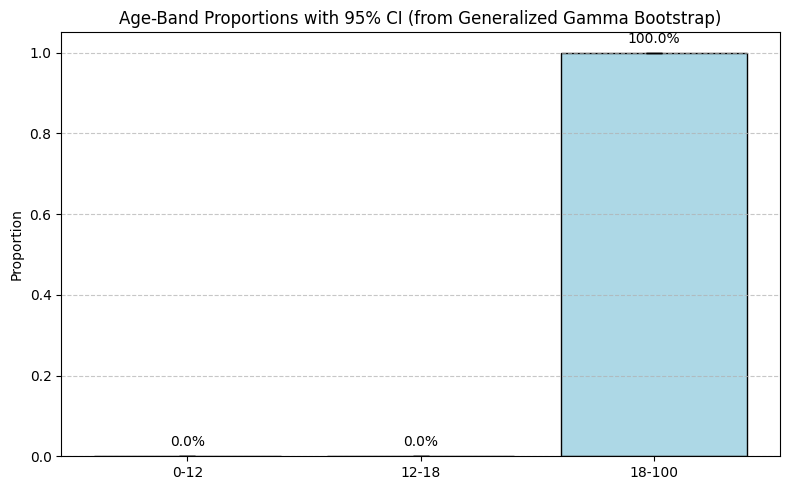

In [30]:
# Todo: Visualize mean proportion and 95% CI using a bar plot and error bars.
import matplotlib.pyplot as plt
import numpy as np

# Extract data from DataFrame
labels = df_summary_gengamma["Age Band"]
means = df_summary_gengamma["Mean Proportion"]
ci_lower = df_summary_gengamma["95% CI Lower"]
ci_upper = df_summary_gengamma["95% CI Upper"]

# Calculate error bars
error_lower = np.maximum(means - ci_lower, 0)
error_upper = np.maximum(ci_upper - means, 0)
error = [error_lower, error_upper]

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, means, yerr=error, capsize=6, color='lightblue', edgecolor='black')

# Annotate percentages
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f"{height:.1%}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

# Format the plot
ax.set_ylabel("Proportion")
ax.set_title("Age-Band Proportions with 95% CI (from Generalized Gamma Bootstrap)")
ax.set_ylim(0, 1.05 * ci_upper.max())
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Sensitivity analysis

### Purpose

In rare disease modelling, we often estimate age-band-specific disease burden using a fitted parametric distribution (eg., Generalized Gamma) based on limited summary statistics. However, these fitted parameters (like shape, power, or scale) are subject to uncertainty due to:
- Sampling variation in reported medians and quantiles
- Assumptions in fitting procedures
- Study heterogeneity

Sensitivity analysis helps us assess how robust our simulated age-band proportions are to small changes in these parameter values.

### Approach

1. Define a range of plausible values for key distribution parameters (eg. plus-minus 10% from fitted a, c, and scale)
2. Simulate onset ages for each parameter combination using the Generalized Gamma distribution. 
3. Calculate proportions of simulated cases that fall into age bands (eg. 0-12, 13-17, and 18+).
4. Compare and visualize results to identify if small changes in parameters lead to material differences in outputs.

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import gengamma

In [32]:
# Define plausible parameter ranges by varying each parameter of the generalized Gamma by minus-plus 10%

# Center values 
a_center = 26.611
c_center = 1.583
scale_center = 8.409


In [33]:
# Defined ±10% variation grid (3 points per parameter)
a_vals = np.round(np.linspace(0.9*a_center, 1.1*a_center, 3), 3)
c_vals = np.round(np.linspace(0.9*c_center, 1.1*c_center, 3), 3)
scale_vals = np.round(np.linspace(0.9*scale_center, 1.1*scale_center, 3), 3)


In [34]:
# Create a DataFrame to summarize the parameter ranges

df_params_overview = pd.DataFrame({
    'Parameter': ['a', 'c', 'scale'],
    'Range (±10%)': [
        f"{a_vals[0]} - {a_vals[2]}",
        f"{c_vals[0]} - {c_vals[2]}",
        f"{scale_vals[0]} - {scale_vals[2]}"
    ]
})

print(df_params_overview)

  Parameter    Range (±10%)
0         a  23.95 - 29.272
1         c   1.425 - 1.741
2     scale    7.568 - 9.25


In [35]:
# Simulate and store age-band proportions for each parameter combination
results = []

for a in a_vals:
    for c in c_vals:
        for scale in scale_vals:
            # Simulate onset ages from the generalized Gamma distribution
            try:
                sim_ages = gengamma(a=a, c=c, scale=scale).rvs(10000)
                
                # Calculate proportions in age bands
                proportions = [
                    np.mean((sim_ages >= 0) & (sim_ages <= 12)),
                    np.mean((sim_ages > 12) & (sim_ages <= 18)),
                    np.mean(sim_ages > 18)
                ]
                
                results.append({
                    'a': a,
                    'c': c,
                    'scale': scale,
                    'Proportion 0-12': proportions[0],
                    'Proportion 13-17': proportions[1],
                    'Proportion 18+': proportions[2]
                })
            except:
                continue  # Skip invalid parameter combinations

In [36]:
# Create a DataFrame from the sensitivity analysis results
df_sensitivity_results = pd.DataFrame(results)
print(df_sensitivity_results.head())

       a      c  scale  Proportion 0-12  Proportion 13-17  Proportion 18+
0  23.95  1.425  7.568              0.0               0.0             1.0
1  23.95  1.425  8.409              0.0               0.0             1.0
2  23.95  1.425  9.250              0.0               0.0             1.0
3  23.95  1.583  7.568              0.0               0.0             1.0
4  23.95  1.583  8.409              0.0               0.0             1.0


In [37]:
# Visualize the sensitivity analysis results
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for fixed scale = 8.409 to simplify visualization
subset = df_sensitivity_results[df_sensitivity_results['scale'] == 8.409]
pivot = subset.pivot(index="a", columns="c", values="Proportion 18+")

print(pivot)


c       1.425  1.583  1.741
a                          
23.950    1.0    1.0    1.0
26.611    1.0    1.0    1.0
29.272    1.0    1.0    1.0


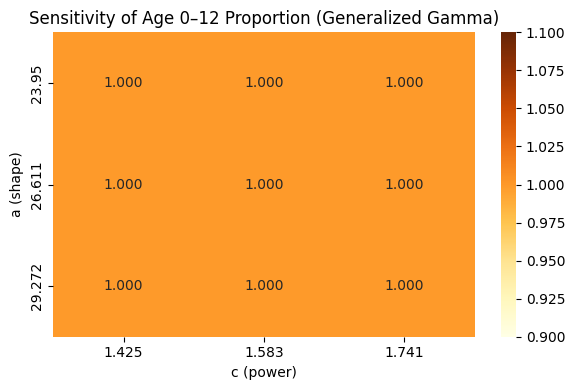

In [38]:
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("Sensitivity of Age 0–12 Proportion (Generalized Gamma)")
plt.xlabel("c (power)")
plt.ylabel("a (shape)")
plt.tight_layout()
plt.show()

### Compare results across multiple age bands visually

Plot line plots or grouped bar plots per age band.

In [39]:
# Reshape result to long format for easier plotting
df_long = df_sensitivity_results.melt(id_vars=['a', 'c', 'scale'], 
                                      value_vars=['Proportion 0-12', 'Proportion 13-17', 'Proportion 18+'],
                                      var_name='Age Band', value_name='Proportion')

print(df_long.head())

       a      c  scale         Age Band  Proportion
0  23.95  1.425  7.568  Proportion 0-12         0.0
1  23.95  1.425  8.409  Proportion 0-12         0.0
2  23.95  1.425  9.250  Proportion 0-12         0.0
3  23.95  1.583  7.568  Proportion 0-12         0.0
4  23.95  1.583  8.409  Proportion 0-12         0.0


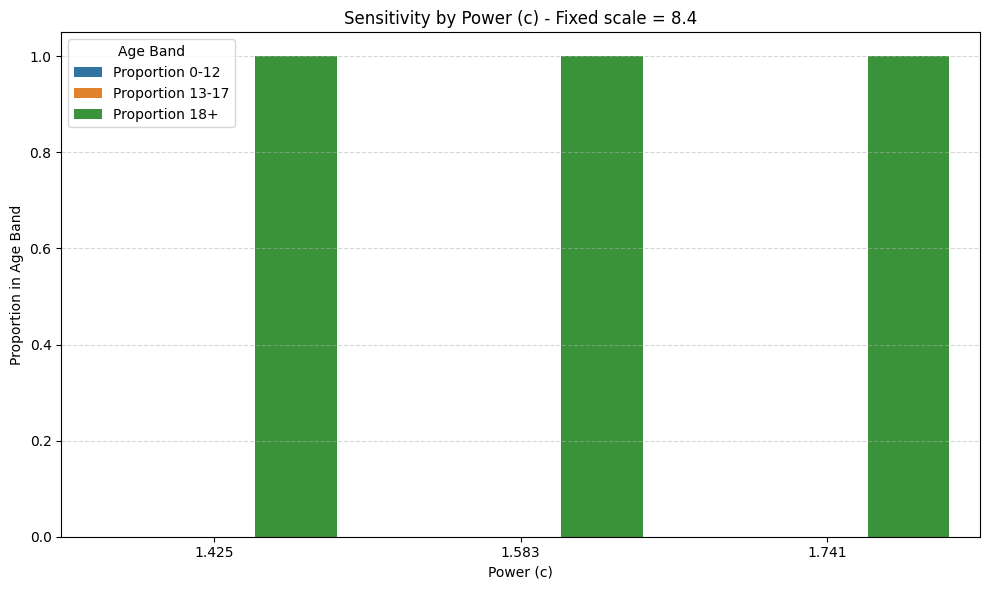

In [40]:
# Plot grouped bar chart by age band 

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for one fixed value (eg. 8.409)
subset = df_long[df_long['scale'] == 8.409]

plt.figure(figsize=(10, 6)) # Set figure size
sns.barplot(data=subset, x='c', y='Proportion', hue='Age Band', errorbar=None)
plt.title("Sensitivity by Power (c) - Fixed scale = 8.4")
plt.xlabel("Power (c)")
plt.ylabel("Proportion in Age Band")
plt.legend(title="Age Band")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

## Sensitivity analysis with Monte Carlo simulation

### Purpose

The current sensitivity analysis based on a fixed ±10% grid has notable limitations. 

To address these, I plan to implement Monte Carlo simulation using fitted distribution parameters, which offers three key advantages:

- Continuous uncertainty representation rather than relying on only low, central, and high values.
- Faster and smoother calculations through the cumulative distribution function (CDF), without the need for inner resampling.
- More stable confidence intervals and compatibility with tornado analysis for identifying key drivers.

### Procedure

1. Draw N parameter triplets from continous priors distributions.
2. Use CDF differences to get exact band probabilities per draw.
3. Aggregate acroos draws to get mean, median and 95% CI. 

### Code for implementation

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import gengamma, norm

In [42]:
# The fitted model object from previous analysis
result_gengamma


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.10243077858152738
        x: [ 2.661e+01  1.583e+00  8.409e+00]
      nit: 88
      jac: [-1.463e-02  1.069e+00 -8.571e-02]
     nfev: 456
     njev: 114
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [43]:
print(result_gengamma.hess_inv)

<3x3 LbfgsInvHessProduct with dtype=float64>


In [44]:
# Get the MLE
theta_hat = result_gengamma.x

print(theta_hat)

[26.61103626  1.58349596  8.40915197]


According to the output of fitted Generalized Gamma model, the key parameters of the distribution inlcudes:
- mean = 26.61
- log SD = 1.58
- Q = 8.41

The parameter mean shifts the curve on the log-time axis; scale controls spread of log times; and Q governs skewness and hazard shape, determining sub-family.

Compute the Hessian numerically at the optimum

In [45]:
import numpy as np
from statsmodels.tools.numdiff import approx_hess

H = approx_hess(theta_hat, gengamma_objective)  # by default, central differences

In [46]:
# Invert the Hessian to get the variance-covariance matrix
vcov_matrix = np.linalg.inv(H)

print(vcov_matrix)

[[ 5.95129550e+02 -1.77608293e+01 -3.15062237e+02]
 [-1.77608293e+01  5.51055889e-01  9.63377691e+00]
 [-3.15062237e+02  9.63377691e+00  1.69340808e+02]]


In [47]:
# Multivariate normal sampling on fitted scale

from numpy.random import default_rng
rng = default_rng(123)
N = 5000

m = theta_hat  # MLE parameter vector
L = np.linalg.cholesky(vcov_matrix)  # Cholesky decomposition of variance-covariance matrix
Z = rng.standard_normal((N, len(m)))  # Standard normal samples

theta_draws = m + Z @ L.T  # MVN samples of parameters
mu_draws, log_sigma_draws, Q_draws = theta_draws.T
sigma_draws = np.exp(log_sigma_draws)

Fitted parameters of generalized Gamma distribution

In [50]:
# Age bands (inclusive of lower, exclusive of upper)
age_bands = [(0, 12), (12, 18), (18, 100)]

This custom function aims to calculate log-scale standard deviation for a log-normal prior, so that approximately 95% of mass falls with ±10% multiplicative of the median.

Derivation

For Y ~ Normal(mu, sigma) the 95% interval is mu ± 1.96sigma, so on the orignal scale exp(mu ± 1.96sigma) gives a multiplicative factor exp(1.96*sigma). Setting that factor = 1.1 (i.e. +10%) give sigma = ln(1.1)/ 1.96

rng.lognormal() is a NumPy random number generator method that draws samples from a log-normal distribution - a distribution where the logarithm of the variable follows normal (Gaussian) distribution.

rng.lognormal(mean=mu_a, sigma=s_log, size=N) draws samples X = exp(Y) where Y ~ Normal(mu_a, s_log)

Note that rng.lognormal equivalent to np.exp(rng.normal(mean, sigma, size))

In [56]:
# Compute band probabilities for each parameter set via CDF
def band_probs_for_draw(a, c, s):
    F = gengamma(a=a, c=c, scale=s).cdf
    p0_12 = F(12.0) - F(0.0)
    p12_18 = F(18.0) - F(12.0)
    p18_100 = F(100.0) - F(18.0)
    return p0_12, p12_18, p18_100

gengamma(a=a, c=c, scale=s) constructs a "frozen" SciPy generalized Gamma distribution with given parameters. Appending .cdf returns that distribution's cumulative distribution function as a callable (i.e., can be called like a function).

What F is: a function F(x) that returns P(x <= x) for X ~ GenGamma(a,c,scale=s). It accepts acalars or numpy arrays and returns probabities in [0,1].



In [ ]:
P = np.array([band_probs_for_draw(a, c, s) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]) # Shape (N, 3)

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [           nan            nan            nan]]


In [61]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [           nan            nan            nan]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [           nan            nan            nan]
 [           nan            nan            nan]]


In [64]:
# Filter out NaNs in all three columns
P = P[~np.isnan(P).any(axis=1)]

In [65]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [8.17154984e-16 4.93084700e-11 9.99937577e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.02810919e-20 2.75611355e-14 9.99997395e-01]]


In [66]:
# Summarize reults
summary = pd.DataFrame({
    'Age Band': ['0-12', '12-18', '18+'],
    'Mean': np.char.mod('%.2f%%', P.mean(axis=0)*100),
    "SD": np.char.mod('%.2f%%', P.std(axis=0)*100),
    "Median": np.char.mod('%.2f%%', np.median(P, axis=0)*100),
    "CI Lower (2.5%)": np.char.mod('%.2f%%', np.percentile(P, 2.5, axis=0)*100),
    "CI Upper (97.5%)": np.char.mod('%.2f%%', np.percentile(P, 97.5, axis=0)*100)
})

print(summary)


  Age Band    Mean      SD   Median CI Lower (2.5%) CI Upper (97.5%)
0     0-12   2.67%  14.00%    0.00%           0.00%           44.47%
1    12-18   1.95%   9.41%    0.00%           0.00%           23.81%
2      18+  95.38%  18.45%  100.00%           9.54%          100.00%
